In [9]:
import sys
sys.path.append('/root/6S062/indoor-loc/Workspace/')
import matplotlib.pyplot as plt
import json
import ibeaconsHelper
import trilateration
import CoreLocation

In [10]:
beacon_locations = {
    3: (62, 0),
    2: (173, 0),
    4: (212, 93),
    5: (309, 173),
    8: (309, 303),
    9: (165, 341),
    6: (45, 110),
    1: (18, 224),
    7: (0, 307)
}

In [11]:
landmark_initial_location = (23, 15)

In [12]:
def add_landmark(dx, dy, steps):
    total_steps, (x, y) = landmark_locations[-1]
    new_landmark = total_steps + steps, (x + dx, y + dy)
    landmark_locations.append(new_landmark)

In [13]:
landmark_locations = [(0, landmark_initial_location)]
add_landmark(96, 0, 4)
add_landmark(0, 66, 3)
add_landmark(55, 0, 2)
add_landmark(0, 175, 9)
add_landmark(-36, 36, 3)
add_landmark(-80, 0, 4)
add_landmark(0, -54, 3)
add_landmark(36, -63, 4)
add_landmark(82, 0, 4)
add_landmark(-109, 0, 5)
add_landmark(0, -90, 4)
add_landmark(52, -4, 2)
add_landmark(0, -66, 3)
add_landmark(146, 0, 7)
add_landmark(0, 324, 16)

In [14]:
# interpolate
walk_locations = [landmark_locations[0]]
for loc1, loc2 in zip(landmark_locations, landmark_locations[1:]):
    step1, (x1, y1) = loc1
    step2, (x2, y2) = loc2
    ds = step2 - step1
    dx, dy = x2 - x1, y2 - y1
    for s in range(1, ds + 1):
        walk_coordinate = (x1 + 1. * s / ds * dx, y1 + 1. * s / ds * dy)
        walk_location = (step1 + s, walk_coordinate)
        walk_locations.append(walk_location)

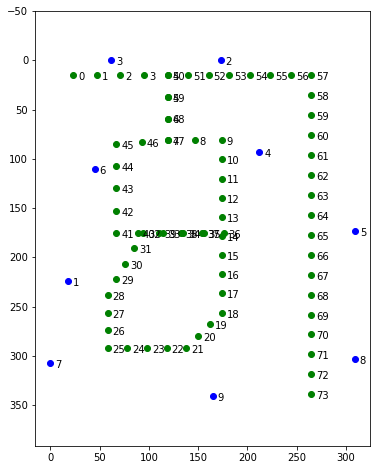

In [27]:
margin = 50
xs, ys = zip(*beacon_locations.values())
axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
fig, ax = plt.subplots(figsize=(6,8))

# assume all beacons in beacon_distances are also in beacon_locations
for minor in beacon_locations:
    x, y = beacon_locations[minor][:2]
    ax.plot(x, y, 'bo')
    ax.annotate(minor, (x, y), xytext=(x + 5, y + 5))

for step, (x, y) in walk_locations:
    ax.plot(x, y, 'go')
    ax.annotate(step, (x, y), xytext=(x + 5, y + 5))

plt.axis(axis_limits)
ax.axis('equal')
plt.gca().invert_yaxis()
plt.show()

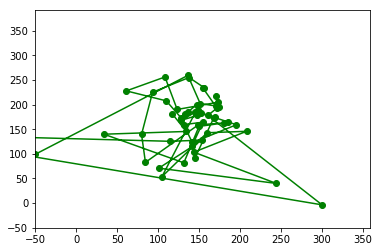

In [33]:
with open('/root/6S062/indoor-loc/Server/collected_data/cattalyya/ibeacons/1525940143200.json', 'r') as f:
    data = json.load(f)
data_by_timestamp = ibeaconsHelper.get_rssi_data_by_timestamp(data)
A = -64
n = 2
conversion = 39.97 # meters to inches
subject_name = "cattalyya"
predicted_locations = CoreLocation.Locations(subject=subject_name)
for timestamp in data_by_timestamp.keys():
    rssi_values = ibeaconsHelper.get_rssi_values(data_by_timestamp, timestamp)
    beacon_distances = ibeaconsHelper.get_beacon_distances_from_rssi(rssi_values, A, n, conversion)
    predicted_loc = trilateration.trilaterate(beacon_locations, beacon_distances, L2=True)
    # TODO: check why None result from trilateration
    if predicted_loc is not None:
        predicted_locations.add_np_point(predicted_loc, timestamp)

# subject_point = CoreLocation.Point2D.numpy_to_point(client_locations[subject_name], None)
predicted_locations.visualize(ax_limits=axis_limits)
# plt.show()
# predicted_locations.plot(ax_limits=axis_limits)

In [34]:
for timestamp in data_by_timestamp.keys():
    rssi_values = ibeaconsHelper.get_rssi_values(data_by_timestamp, timestamp)
    print rssi_values
print(len(data_by_timestamp.keys()))

{1: -68, 2: -78, 3: -71, 4: -74, 5: -67, 6: -73, 7: -69, 8: -79, 9: -77}
{1: -71, 2: -71, 3: -69, 4: -64, 5: -69, 6: -74, 7: -63, 8: -79, 9: -79}
{1: -70, 2: -71, 3: -78, 4: -68, 5: -69, 6: -74, 7: -66, 8: -89, 9: -79}
{1: -66, 2: -70, 3: -73, 4: -70, 5: -69, 6: -73, 7: -72, 8: -77, 9: -88}
{1: -73, 2: -68, 3: -74, 4: -70, 5: -69, 6: -72, 7: -69, 8: -74, 9: -79}
{1: -77, 2: -69, 3: -68, 4: -70, 5: -63, 6: -77, 7: -70, 8: -69, 9: -77}
{1: -77, 2: -69, 3: -68, 4: -68, 5: -73, 6: -66, 7: -72, 8: -73, 9: -70}
{1: -77, 2: -71, 3: -68, 4: -72, 5: -69, 6: -66, 7: -72, 8: -87, 9: -79}
{1: -67, 2: -75, 3: -71, 4: -69, 5: -67, 6: -65, 7: -72, 8: -87, 9: -71}
{1: -59, 2: -67, 3: -81, 4: -69, 5: -67, 6: -84, 7: -64, 8: -87, 9: -71}
{1: -63, 2: -67, 3: -81, 4: -83, 5: -69, 6: -80, 7: -68, 8: -73, 9: -73}
{1: -68, 2: -73, 3: -82, 4: -73, 5: -75, 6: -80, 7: -68, 8: -73, 9: -74}
{1: -68, 2: -73, 3: -82, 4: -68, 5: -78, 6: -80, 7: -68, 8: -70, 9: -74}
{1: -68, 2: -67, 3: -72, 4: -68, 5: -71, 6: -80, 7: